In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from collections import Counter
import optuna
import numpy as np
import plotly.io as pio
pio.renderers.defaults = 'png'
import geopandas as gpd
from shapely.geometry import Point, Polygon
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import LinearSVC
from sklearn.ensemble import StackingClassifier, BaggingRegressor, StackingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import StackingClassifier, BaggingClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import NearestNeighbors
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import catboost
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)

`Датасет`: https://drive.google.com/file/d/1fABzTyH2tlMYjJyDOAnwkH0HkWAG27_L/view?usp=sharing

`Цель работы`: требуется обучить модель, которая сможет предсказать популярность объявления - исходя из этих предсказаний аналитики риэлторской компании будут редактировать описания объявлений, выставляемых на этой платформе.

`План`: 
- EDA
- Feature engineering
- Выбор целевой метрики
- Проведение экспериментов
- Анализ ошибок модели

## EDA

In [2]:
df = pd.read_csv('houses_ads_popularity.csv')
df['created'] = pd.to_datetime(df['created'])

In [3]:
df.head()

,Id,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address,TARGET
0,57094,1.0,3,0,2016-05-19 18:06:27,A FABULOUS 3BR IN MIDTOWN WEST! PERFECT APAR...,HOW AMAZING IS THIS MIDTOWN WEST STEAL!! NO FE...,"['Laundry In Unit', 'No Fee', 'Elevator']",40.7647,7039994,-73.9918,4bdc3d8c1aaa90d997ce2cb77680679b,['https://photos.renthop.com/2/7039994_07be01b...,4495,W 50 & AVE 10,medium
1,33389,1.0,1,9225efdfb57a50bf3ec17ebab082f94a,2016-06-16 02:01:49,Renovated Kitchen and Bathroom!,55 River Drive South,"['Dogs Allowed', 'Cats Allowed', 'No Fee']",40.7275,7166774,-74.0322,e5808a5e6cc13988fe596704428d38d5,['https://photos.renthop.com/2/7166774_03cf63a...,2570,55 River Drive South,medium
2,60458,1.0,0,320de7d3cc88e50a7fbbcfde1e825d21,2016-05-04 02:42:50,RARE AND BEST DEAL ON THE MARKET!!!! PERFECT S...,W 77 Street,"['Elevator', 'Hardwood Floors']",40.7798,6962716,-73.9751,d69d4e111612dd12ef864031c1148543,['https://photos.renthop.com/2/6962716_ec7f56f...,1795,22 W 77 Street,low
3,53048,1.0,2,ce6d18bf3238e668b2bf23f4110b7b67,2016-05-12 05:57:56,Newly renovated flex 2 apartment offers the ne...,John Street,"['Swimming Pool', 'Doorman', 'Elevator', 'Fitn...",40.7081,7002458,-74.0065,e6472c7237327dd3903b3d6f6a94515a,['https://photos.renthop.com/2/7002458_93f4010...,3400,100 John Street,low
4,592,1.0,3,fee4d465932160318364d9d48d272879,2016-06-16 06:06:15,LOW FEE apartments do not come around like thi...,West 16th Street,"['Laundry in Building', 'Laundry in Unit', 'Di...",40.7416,7170465,-74.0025,6fba9b3a8327c607b8b043716efee684,['https://photos.renthop.com/2/7170465_9c3f173...,5695,321 West 16th Street,low


In [4]:
df.tail()

,Id,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address,TARGET
34541,25582,1.0,1,14fdc4b01ae44b025f6c4d28c9097e5f,2016-06-16 02:12:57,Newly renovated bedroom apartment located off ...,29th St,['No pets'],40.7653,7166867,-73.9248,e6472c7237327dd3903b3d6f6a94515a,['https://photos.renthop.com/2/7166867_625fde3...,1950,30-95 29th St,low
34542,50013,1.0,0,9b6cf886379a2511f8c633c84028efe7,2016-05-10 03:17:32,All apartments are newly renovated featuring: ...,E 1st St,"['Pre-War', 'Laundry in Unit', 'Dishwasher', '...",40.7239,6989251,-73.9901,5599e962719af3ccc2976855c2d5893c,['https://photos.renthop.com/2/6989251_42a4884...,2600,39 E 1st St,medium
34543,111475,2.0,2,0,2016-04-21 03:29:35,"<![CDATA[2 bedrooms, 5110, Astoria / Long Isla...",50th Avenue,[],40.7437,6905568,-73.9585,e6472c7237327dd3903b3d6f6a94515a,['https://photos.renthop.com/2/6905568_01602e3...,5110,2-01 50th Avenue,low
34544,71184,1.0,2,8754cae39f6e053974aa2337017eb3c1,2016-05-14 02:27:47,CooperCooper.com :: Listing ID #10_0385; 400 W...,400 West 56th Street,"['Laundry in Unit', 'Dishwasher', 'Cats Allowe...",40.7673,7010187,-73.9866,6e5c10246156ae5bdcd9b487ca99d96a,['https://photos.renthop.com/2/7010187_ab1db5d...,3400,400 West 56th Street,medium
34545,117473,1.0,2,a068b783287190d47d1564ab4d898675,2016-04-05 03:35:52,Renovated two bedroom apartment with beautiful...,E 82 Street,[],40.7765,6824588,-73.9571,e0f4c69279ce5ae6421b39d46303554b,['https://photos.renthop.com/2/6824588_b997d59...,2950,158 E 82 Street,medium


In [5]:
df.shape

(34546, 16)

In [6]:
df.columns

Index(['Id', 'bathrooms', 'bedrooms', 'building_id', 'created', 'description',
       'display_address', 'features', 'latitude', 'listing_id', 'longitude',
       'manager_id', 'photos', 'price', 'street_address', 'TARGET'],
      dtype='object')

In [7]:
df.dtypes

Id                          int64
bathrooms                 float64
bedrooms                    int64
building_id                object
created            datetime64[ns]
description                object
display_address            object
features                   object
latitude                  float64
listing_id                  int64
longitude                 float64
manager_id                 object
photos                     object
price                       int64
street_address             object
TARGET                     object
dtype: object

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34546 entries, 0 to 34545
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Id               34546 non-null  int64         
 1   bathrooms        34546 non-null  float64       
 2   bedrooms         34546 non-null  int64         
 3   building_id      34546 non-null  object        
 4   created          34546 non-null  datetime64[ns]
 5   description      33509 non-null  object        
 6   display_address  34458 non-null  object        
 7   features         34546 non-null  object        
 8   latitude         34546 non-null  float64       
 9   listing_id       34546 non-null  int64         
 10  longitude        34546 non-null  float64       
 11  manager_id       34546 non-null  object        
 12  photos           34546 non-null  object        
 13  price            34546 non-null  int64         
 14  street_address   34542 non-null  objec

In [9]:
df.describe()

,Id,bathrooms,bedrooms,latitude,listing_id,longitude,price
count,34546.000000,34546.000000,34546.000000,34546.000000,3.454600e+04,34546.000000,3.454600e+04
mean,61873.351618,1.211182,1.540815,40.741878,7.024901e+06,-73.954803,3.888823e+03
std,35718.160364,0.496217,1.116735,0.622257,1.263556e+05,1.126953,2.630662e+04
min,6.000000,0.000000,0.000000,0.000000,6.811965e+06,-75.521400,4.500000e+01
25%,30839.250000,1.000000,1.000000,40.728000,6.917211e+06,-73.991700,2.500000e+03
50%,61822.500000,1.000000,1.000000,40.751600,7.021834e+06,-73.977900,3.150000e+03
75%,92705.500000,1.000000,2.000000,40.774000,7.130020e+06,-73.954900,4.100000e+03
max,124009.000000,6.000000,8.000000,44.603800,7.742803e+06,0.000000,4.490000e+06


In [10]:
df.loc[df.duplicated()]

,Id,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address,TARGET


In [11]:
df.isna().sum()

Id                    0
bathrooms             0
bedrooms              0
building_id           0
created               0
description        1037
display_address      88
features              0
latitude              0
listing_id            0
longitude             0
manager_id            0
photos                0
price                 0
street_address        4
TARGET                0
dtype: int64

In [12]:
df[['description', 'display_address','street_address']]

,description,display_address,street_address
0,A FABULOUS 3BR IN MIDTOWN WEST! PERFECT APAR...,HOW AMAZING IS THIS MIDTOWN WEST STEAL!! NO FE...,W 50 & AVE 10
1,Renovated Kitchen and Bathroom!,55 River Drive South,55 River Drive South
2,RARE AND BEST DEAL ON THE MARKET!!!! PERFECT S...,W 77 Street,22 W 77 Street
3,Newly renovated flex 2 apartment offers the ne...,John Street,100 John Street
4,LOW FEE apartments do not come around like thi...,West 16th Street,321 West 16th Street
...,...,...,...
34541,Newly renovated bedroom apartment located off ...,29th St,30-95 29th St
34542,All apartments are newly renovated featuring: ...,E 1st St,39 E 1st St
34543,"<![CDATA[2 bedrooms, 5110, Astoria / Long Isla...",50th Avenue,2-01 50th Avenue
34544,CooperCooper.com :: Listing ID #10_0385; 400 W...,400 West 56th Street,400 West 56th Street


In [13]:
df['year'] = df['created'].dt.year
df['month'] = df['created'].dt.month
df['day'] = df['created'].dt.day
df['hour'] = df['created'].dt.hour
df['minute'] = df['created'].dt.minute
df['second'] = df['created'].dt.second
df['weekday'] = df['created'].dt.weekday
df = df.drop(columns=['created'])

In [14]:
df.head()

,Id,bathrooms,bedrooms,building_id,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address,TARGET,year,month,day,hour,minute,second,weekday
0,57094,1.0,3,0,A FABULOUS 3BR IN MIDTOWN WEST! PERFECT APAR...,HOW AMAZING IS THIS MIDTOWN WEST STEAL!! NO FE...,"['Laundry In Unit', 'No Fee', 'Elevator']",40.7647,7039994,-73.9918,4bdc3d8c1aaa90d997ce2cb77680679b,['https://photos.renthop.com/2/7039994_07be01b...,4495,W 50 & AVE 10,medium,2016,5,19,18,6,27,3
1,33389,1.0,1,9225efdfb57a50bf3ec17ebab082f94a,Renovated Kitchen and Bathroom!,55 River Drive South,"['Dogs Allowed', 'Cats Allowed', 'No Fee']",40.7275,7166774,-74.0322,e5808a5e6cc13988fe596704428d38d5,['https://photos.renthop.com/2/7166774_03cf63a...,2570,55 River Drive South,medium,2016,6,16,2,1,49,3
2,60458,1.0,0,320de7d3cc88e50a7fbbcfde1e825d21,RARE AND BEST DEAL ON THE MARKET!!!! PERFECT S...,W 77 Street,"['Elevator', 'Hardwood Floors']",40.7798,6962716,-73.9751,d69d4e111612dd12ef864031c1148543,['https://photos.renthop.com/2/6962716_ec7f56f...,1795,22 W 77 Street,low,2016,5,4,2,42,50,2
3,53048,1.0,2,ce6d18bf3238e668b2bf23f4110b7b67,Newly renovated flex 2 apartment offers the ne...,John Street,"['Swimming Pool', 'Doorman', 'Elevator', 'Fitn...",40.7081,7002458,-74.0065,e6472c7237327dd3903b3d6f6a94515a,['https://photos.renthop.com/2/7002458_93f4010...,3400,100 John Street,low,2016,5,12,5,57,56,3
4,592,1.0,3,fee4d465932160318364d9d48d272879,LOW FEE apartments do not come around like thi...,West 16th Street,"['Laundry in Building', 'Laundry in Unit', 'Di...",40.7416,7170465,-74.0025,6fba9b3a8327c607b8b043716efee684,['https://photos.renthop.com/2/7170465_9c3f173...,5695,321 West 16th Street,low,2016,6,16,6,6,15,3


In [15]:
df.year.value_counts()

2016    34546
Name: year, dtype: int64

In [16]:
df.Id.value_counts()

57094     1
32593     1
78295     1
39190     1
89177     1
         ..
52935     1
95135     1
104296    1
76533     1
117473    1
Name: Id, Length: 34546, dtype: int64

In [17]:
df.listing_id.value_counts()

7039994    1
7181888    1
7026656    1
7156894    1
6898276    1
          ..
6976530    1
6888240    1
6893070    1
7009322    1
6824588    1
Name: listing_id, Length: 34546, dtype: int64

In [18]:
len(df.building_id.unique())

6378

In [19]:
df.building_id.value_counts().head(20)

0                                   5713
96274288c84ddd7d5c5d8e425ee75027     196
80a120d6bc3aba97f40fee8c2204524b     161
11e1dec9d14b1a9e528386a2504b3afc     151
bb8658a3e432fb62a440615333376345     141
f68bf347f99df026f4faad43cc604048     134
ce6d18bf3238e668b2bf23f4110b7b67     119
d0234abbc01a982d54e8d446acc03405     114
c94301249b8c09429d329864d58e5b82     114
128d4af0683efc5e1eded8dc8044d5e3     111
57ef86c28a8ae482dc3a3c3af28e8e48     105
cb14c4f807f23ecee1f7469b5159d2de     104
8e3b8c607c3edcf3de131c24f0390179     102
9c18bf871b97492b96d8ddb800591f1b     101
ea9045106c4e1fe52853b6af941f1c69      95
18f6eb16d2f3e9885cb4a5d0a40791c6      93
a01c99eb2cfdde327e1691e17d6696ba      91
093f64f52a6e43ba5e8f12bec8200554      90
6ce872b483cfcbb32ea805604d44ef5f      90
7967a1280bf3f7644500fc79d2696b0e      89
Name: building_id, dtype: int64

Смело выкидываем `Id` и `listing_id`, потому что это просто нумерковка даннных и никакого смысла в этих столбцах нет. `Building_id` тоже можно удалить, потому что:
- а) слишком много уникальных значений
- б) скорее всего это просто нумерация для сайта, т.е. попросту лишние данные для модели
- в) у нас всё ещё есть широта и долгота, что заменяет эти id'шники и позволяет идентифицировать определённое здание

Удалим `year`, так как объявления одного года

In [20]:
df = df.drop(columns=['year', 'Id', 'listing_id', 'building_id'])

In [21]:
df.TARGET.value_counts()

low       23999
medium     7860
high       2687
Name: TARGET, dtype: int64

In [22]:
df['TARGET'].head()

0    medium
1    medium
2       low
3       low
4       low
Name: TARGET, dtype: object

In [23]:
conditions = [(df['TARGET'] == 'low'), (df['TARGET'] == 'medium'), (df['TARGET'] == 'high')]
choices  = [0, 1, 2]
df['TARGET'] = np.select(conditions, choices)

<AxesSubplot:title={'center':'Распределение целевой метки'}, ylabel='TARGET'>

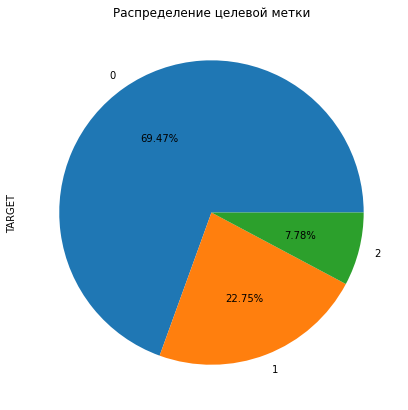

In [24]:
df["TARGET"].value_counts().plot(
                 kind='pie',
                 title='Распределение целевой метки',
                 figsize=(7, 7),
                 autopct='%.2f%%')

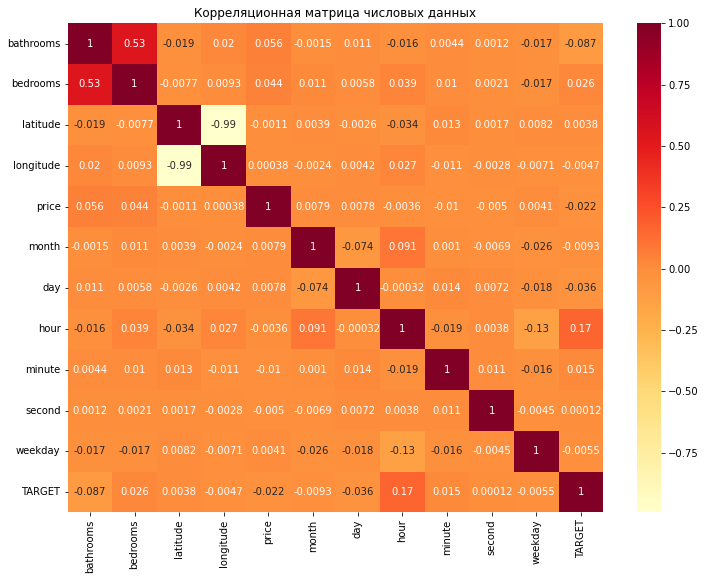

In [25]:
fig, ax = plt.subplots(figsize=(12,9))
dataplot=sns.heatmap(df[['bathrooms', 'bedrooms', 'latitude', 'longitude', 'price',
                         'month', 'day', 'hour', 'minute', 'second', 'weekday', 'TARGET']].corr(),
                     cmap='YlOrRd',
                     center=0.0,
                     annot=True,
                     ax=ax).set(title="Корреляционная матрица числовых данных")


Text(0, 0.5, 'Количество объявлений')

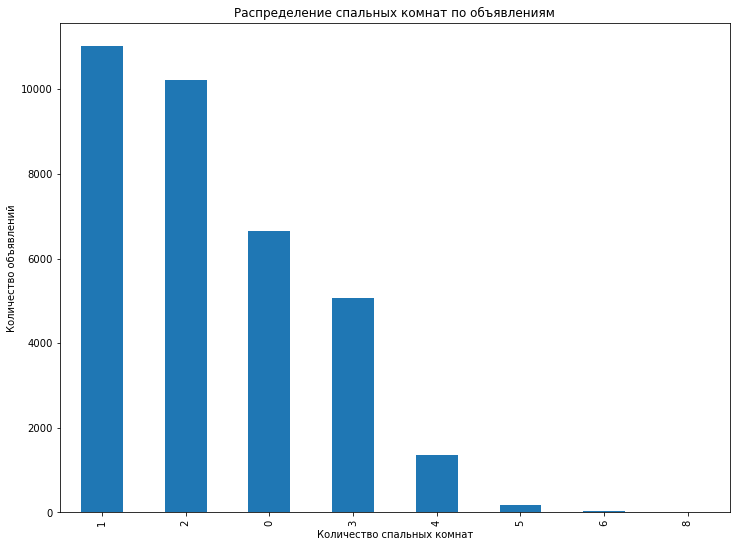

In [26]:
fig, ax = plt.subplots(figsize=(12,9))
ax = df['bedrooms'].value_counts().plot(kind='bar', title='Распределение спальных комнат по объявлениям')
ax.set_xlabel('Количество спальных комнат')
ax.set_ylabel('Количество объявлений')

Text(0, 0.5, 'Количество объявлений')

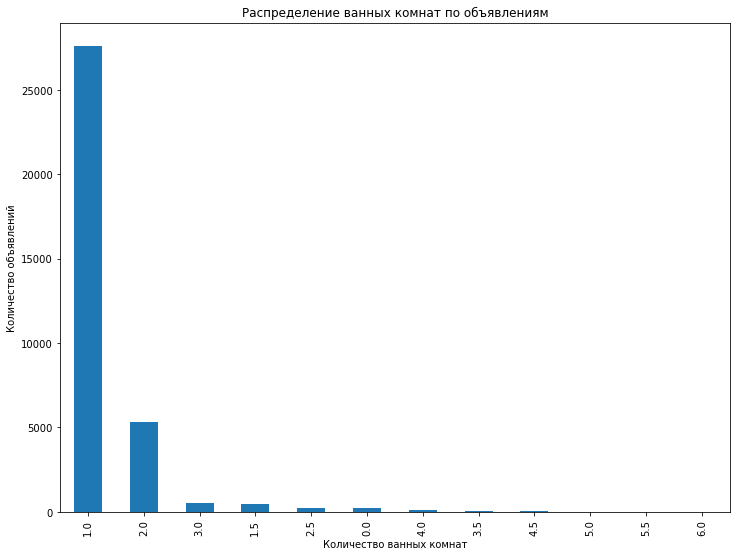

In [27]:
fig, ax = plt.subplots(figsize=(12,9))
ax = df['bathrooms'].value_counts().plot(kind='bar', title='Распределение ванных комнат по объявлениям')
ax.set_xlabel('Количество ванных комнат')
ax.set_ylabel('Количество объявлений')

Так сразу и незаметно, что bathrooms представлены типом float, приведём к int

In [28]:
df["bathrooms"] = df["bathrooms"].astype('int64')

Text(0, 0.5, 'Количество объявлений')

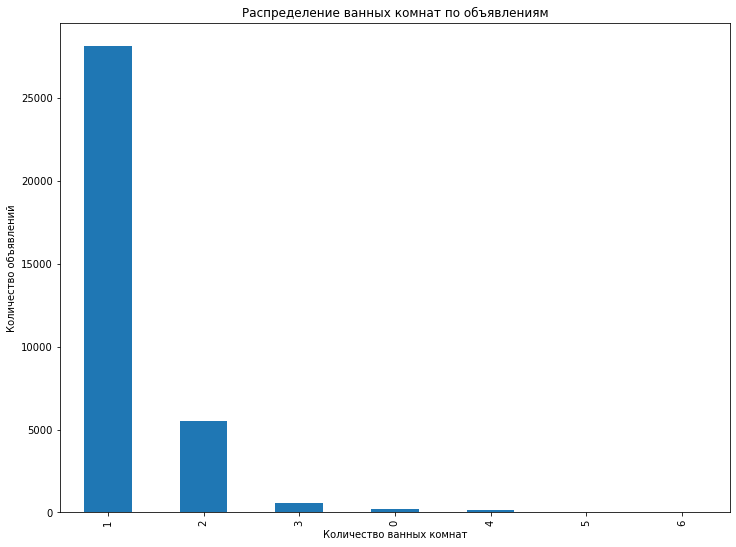

In [29]:
fig, ax = plt.subplots(figsize=(12,9))
ax = df['bathrooms'].value_counts().plot(kind='bar', title='Распределение ванных комнат по объявлениям')
ax.set_xlabel('Количество ванных комнат')
ax.set_ylabel('Количество объявлений')

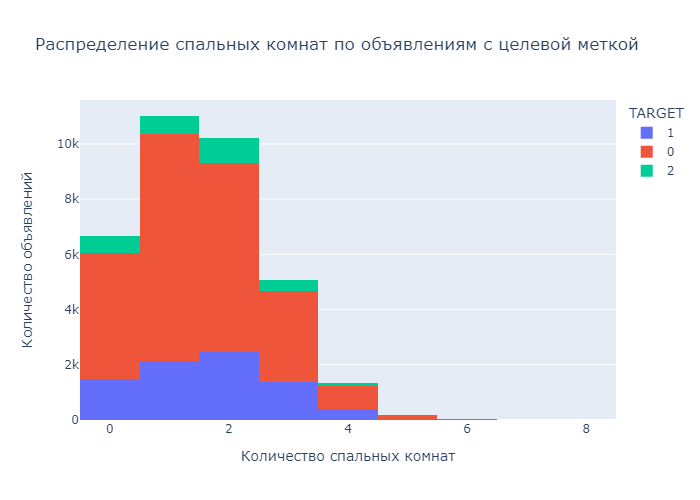

In [30]:
fig = px.histogram(df, x='bedrooms', color='TARGET',
                   title='Распределение спальных комнат по объявлениям с целевой меткой'
                  ).update_layout(
                    yaxis_title='Количество объявлений',
    xaxis_title='Количество спальных комнат')
fig.show('png')

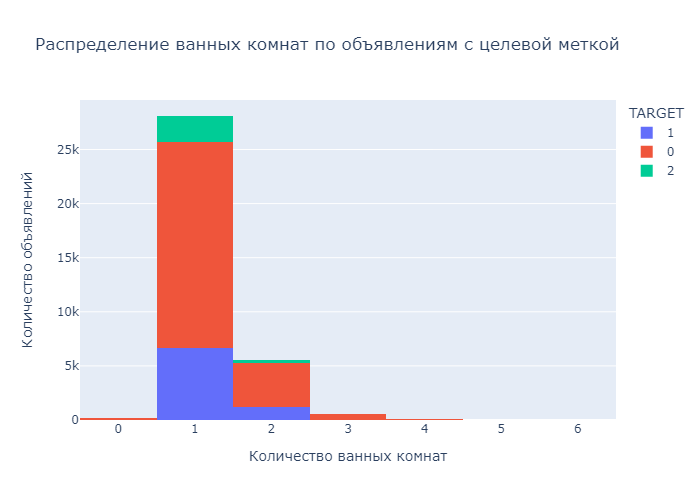

In [31]:
fig = px.histogram(df, x='bathrooms', color='TARGET',
                   title='Распределение ванных комнат по объявлениям с целевой меткой'
                  ).update_layout(
                    yaxis_title='Количество объявлений',
    xaxis_title='Количество ванных комнат')
fig.show('png')

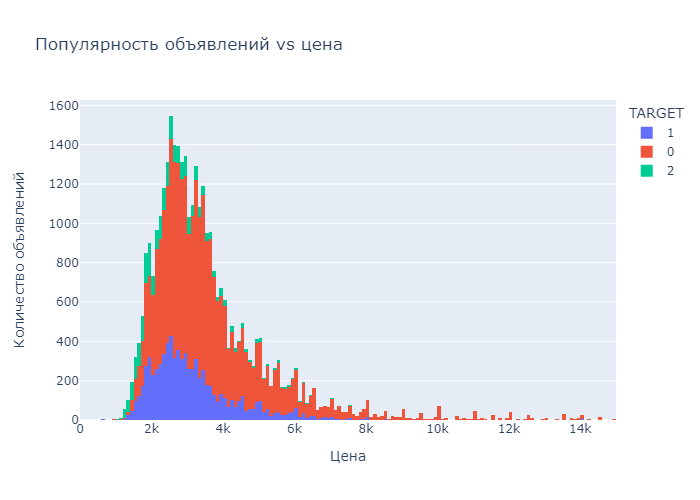

In [32]:
df_cut = df.query('price < 15000') # если цена в таком диапазоне
fig = px.histogram(df_cut, x='price',
                   color='TARGET',
                   title='Популярность объявлений vs цена'
                  ).update_layout(
                    yaxis_title='Количество объявлений',
                    xaxis_title='Цена')

fig.show('png')

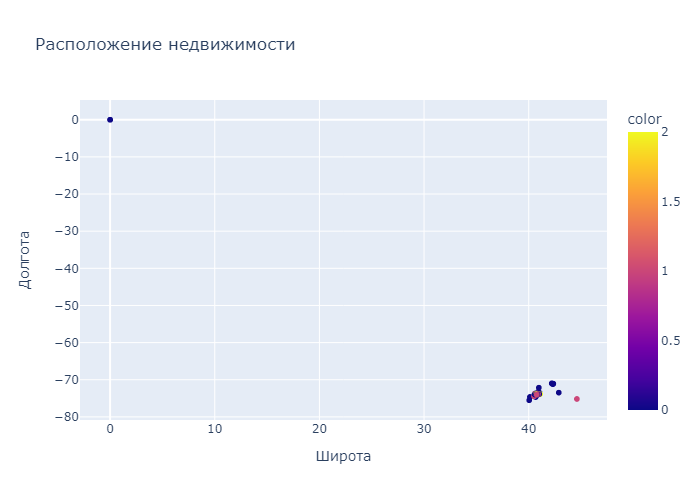

In [33]:
fig = px.scatter(x=df['latitude'], y=df['longitude'], 
                 title='Расположение недвижимости', 
                 color=df.TARGET,
                 labels={'x':'Широта', 'y':'Долгота'})


fig.show('png')

In [34]:
df[['latitude', 'longitude']][(df['latitude'] == 0) & (df['longitude'] == 0)].value_counts()

latitude  longitude
0.0       0.0          8
dtype: int64

In [35]:
df = df.drop(df[(df['latitude'] == 0) & (df['longitude'] == 0)].index)

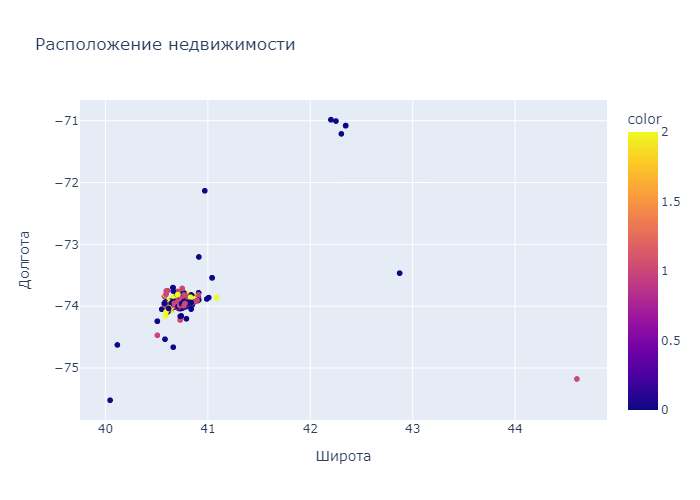

In [36]:
fig = px.scatter(x=df['latitude'], y=df['longitude'], 
                 title='Расположение недвижимости', 
                 color=df.TARGET,
                 labels={'x':'Широта', 'y':'Долгота'})


fig.show('png')

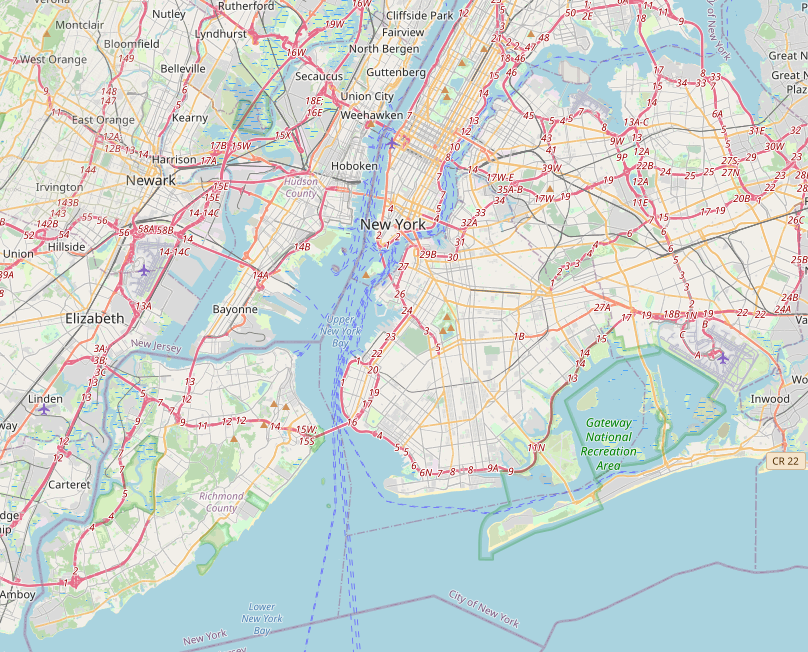

In [37]:
street_map = gpd.read_file('./geo_export_d112483f-e2b1-4eee-a96a-5ea432dab109.shp')
crs = {'init':'epsg:4326'}
geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
geo_df = gpd.GeoDataFrame(df.copy(),
 crs = crs,
 geometry = geometry)

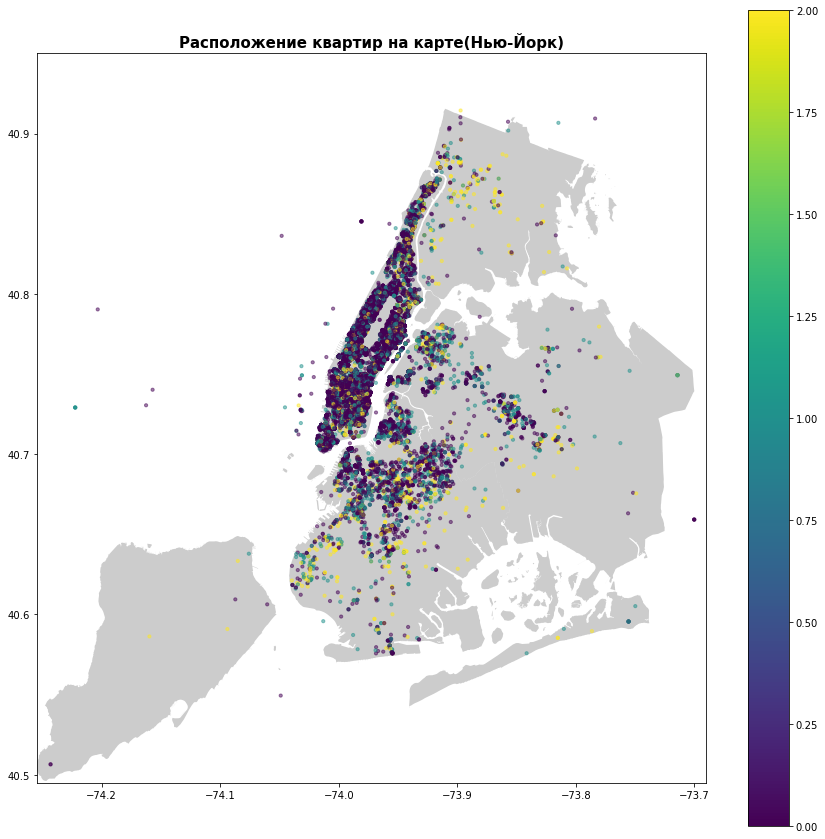

In [38]:
fig, ax = plt.subplots(figsize=(15, 15))
street_map.plot(ax=ax, alpha=0.4, color='grey')
geo_df.plot(column='TARGET',ax=ax,alpha=0.5, legend=True,markersize=10)
plt.title('Расположение квартир на карте(Нью-Йорк)', fontsize=15,fontweight='bold')
plt.xlim(-74.255, -73.69)
plt.ylim(40.495, 40.95)
plt.show()

In [39]:
df[['description', 'display_address', 'street_address']]

,description,display_address,street_address
0,A FABULOUS 3BR IN MIDTOWN WEST! PERFECT APAR...,HOW AMAZING IS THIS MIDTOWN WEST STEAL!! NO FE...,W 50 & AVE 10
1,Renovated Kitchen and Bathroom!,55 River Drive South,55 River Drive South
2,RARE AND BEST DEAL ON THE MARKET!!!! PERFECT S...,W 77 Street,22 W 77 Street
3,Newly renovated flex 2 apartment offers the ne...,John Street,100 John Street
4,LOW FEE apartments do not come around like thi...,West 16th Street,321 West 16th Street
...,...,...,...
34541,Newly renovated bedroom apartment located off ...,29th St,30-95 29th St
34542,All apartments are newly renovated featuring: ...,E 1st St,39 E 1st St
34543,"<![CDATA[2 bedrooms, 5110, Astoria / Long Isla...",50th Avenue,2-01 50th Avenue
34544,CooperCooper.com :: Listing ID #10_0385; 400 W...,400 West 56th Street,400 West 56th Street


Все эти три колонки текстовые. 
- description (описание), можно заменить на 1 если описание есть, на 0 если нет
- display_address (отображаемый адрес) - у нас есть широта и долгота, поэтому колонку можно отбросить
- street_address - примерно то же самое, что и display_address, выкидываем.

In [40]:
df['description'] = df['description'].apply(lambda x: 0 if x == '' else 1)

In [41]:
df = df.drop(columns=['display_address', 'street_address'])

In [42]:
len(df.features.unique())

8238

In [43]:
df.features.value_counts()

[]                                                                                                                                                                                                                                       2218
['Pre-War', 'Dogs Allowed', 'Cats Allowed']                                                                                                                                                                                               984
['Cats Allowed', 'Dogs Allowed']                                                                                                                                                                                                          733
['Hardwood Floors']                                                                                                                                                                                                                       727
['Pre-War']                                     

In [44]:
df.features.unique()

array(["['Laundry In Unit', 'No Fee', 'Elevator']",
       "['Dogs Allowed', 'Cats Allowed', 'No Fee']",
       "['Elevator', 'Hardwood Floors']", ...,
       "['Roof Deck', 'Doorman', 'Elevator', 'Fitness Center', 'Pre-War', 'Laundry in Building', 'Wheelchair Access', 'No Fee']",
       "['Cats Allowed', 'Dogs Allowed', 'Doorman', 'Elevator', 'Fitness Center', 'Roof Deck', 'Garden/Patio', 'Loft']",
       "['Roof Deck', 'Dining Room', 'Balcony', 'Doorman', 'Elevator', 'Fitness Center', 'Laundry in Building', 'High Speed Internet', 'Dishwasher', 'Hardwood Floors', 'Wheelchair Access', 'Outdoor Space', 'Dogs Allowed', 'Cats Allowed']"],
      dtype=object)

Посмотрим на колонку каких-то фичей. Возможно, можно сделать OneHotEncoding.

In [45]:
arr = []
for el in df.features.unique():
    if el not in arr:
        t = el[1:-1].replace("'", '').split(', ')
        for _ in t:
            if _ not in arr:
                arr.append(_)

In [46]:
len(arr)

1243

1243 слишком много, но нужно посмотреть на распределение. Можно взять самые распространённые.

array([[<AxesSubplot:title={'center':'1'}>]], dtype=object)

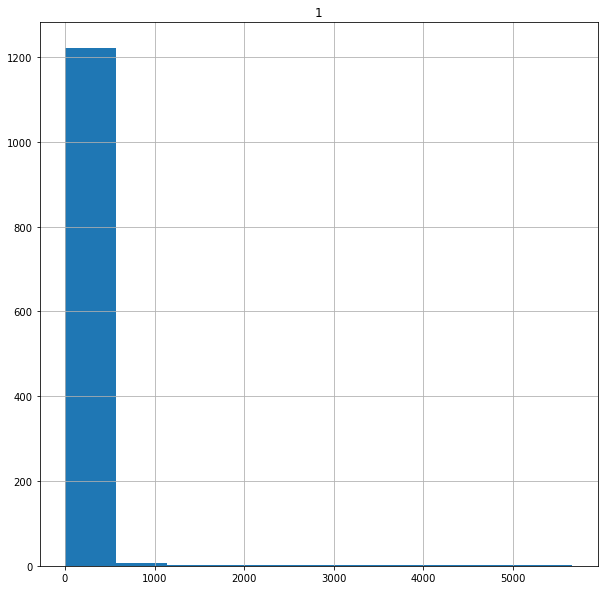

In [47]:
arr = []
for el in df.features.unique():
    if el not in arr:
        t = el[1:-1].replace("'", '').split(', ')
        for _ in t:
            arr.append(_)
dct = sorted(dict(Counter(arr)).items(), key=lambda x:x[1], reverse=True)            
pd.DataFrame(dct).hist(figsize=(10,10))

In [48]:
pd.DataFrame(dct).head(415)

,0,1
0,Elevator,5663
1,Hardwood Floors,4903
2,Dishwasher,4705
3,Doorman,4604
4,Cats Allowed,4318
...,...,...
410,On-site parking available,2
411,Free WiFi in Club lounge,2
412,Multi Level,2
413,Free brealfast,1


In [49]:
pd.DataFrame(dct).head(17)

,0,1
0,Elevator,5663
1,Hardwood Floors,4903
2,Dishwasher,4705
3,Doorman,4604
4,Cats Allowed,4318
5,Laundry in Building,3950
6,Dogs Allowed,3946
7,No Fee,3929
8,Fitness Center,3324
9,Laundry in Unit,2388


Предлагаю взять топ-17 фич(которых не менее 1000, а то иначе по отношению к общему кол-ву данных их будет мало), добавить их количество. 

In [50]:
top17 = pd.DataFrame(dct).head(17)[0].to_numpy()
top17

array(['Elevator', 'Hardwood Floors', 'Dishwasher', 'Doorman',
       'Cats Allowed', 'Laundry in Building', 'Dogs Allowed', 'No Fee',
       'Fitness Center', 'Laundry in Unit', 'Outdoor Space', 'Roof Deck',
       'Dining Room', 'Pre-War', 'High Speed Internet', 'Balcony',
       'Terrace'], dtype=object)

In [51]:
_ = 16
for col in top17:
    arr = []
    for el in df['features']:
        arr.append(1 if col in el else 0)
    df.insert(loc=_, column=col, value=arr)
    _ += 1

In [52]:
def func(x):
    return len(x[1:-1].replace("'", '').split(', '))
df['quantity_of_feature'] = df['features'].apply(func)

In [53]:
df.head()

,bathrooms,bedrooms,description,features,latitude,longitude,manager_id,photos,price,TARGET,month,day,hour,minute,second,weekday,Elevator,Hardwood Floors,Dishwasher,Doorman,Cats Allowed,Laundry in Building,Dogs Allowed,No Fee,Fitness Center,Laundry in Unit,Outdoor Space,Roof Deck,Dining Room,Pre-War,High Speed Internet,Balcony,Terrace,quantity_of_feature
0,1,3,1,"['Laundry In Unit', 'No Fee', 'Elevator']",40.7647,-73.9918,4bdc3d8c1aaa90d997ce2cb77680679b,['https://photos.renthop.com/2/7039994_07be01b...,4495,1,5,19,18,6,27,3,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,3
1,1,1,1,"['Dogs Allowed', 'Cats Allowed', 'No Fee']",40.7275,-74.0322,e5808a5e6cc13988fe596704428d38d5,['https://photos.renthop.com/2/7166774_03cf63a...,2570,1,6,16,2,1,49,3,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,3
2,1,0,1,"['Elevator', 'Hardwood Floors']",40.7798,-73.9751,d69d4e111612dd12ef864031c1148543,['https://photos.renthop.com/2/6962716_ec7f56f...,1795,0,5,4,2,42,50,2,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
3,1,2,1,"['Swimming Pool', 'Doorman', 'Elevator', 'Fitn...",40.7081,-74.0065,e6472c7237327dd3903b3d6f6a94515a,['https://photos.renthop.com/2/7002458_93f4010...,3400,0,5,12,5,57,56,3,1,1,1,1,0,0,0,1,1,1,0,0,0,0,0,0,0,8
4,1,3,1,"['Laundry in Building', 'Laundry in Unit', 'Di...",40.7416,-74.0025,6fba9b3a8327c607b8b043716efee684,['https://photos.renthop.com/2/7170465_9c3f173...,5695,0,6,16,6,6,15,3,0,1,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,4


Также предлагаю оставить photos, но заменить на количество фотографий.

In [54]:
def func(x):
    return len(x[1:-1].replace("'", '').split(', '))
df['photos'] = df['photos'].apply(func)

In [55]:
df.head()

,bathrooms,bedrooms,description,features,latitude,longitude,manager_id,photos,price,TARGET,month,day,hour,minute,second,weekday,Elevator,Hardwood Floors,Dishwasher,Doorman,Cats Allowed,Laundry in Building,Dogs Allowed,No Fee,Fitness Center,Laundry in Unit,Outdoor Space,Roof Deck,Dining Room,Pre-War,High Speed Internet,Balcony,Terrace,quantity_of_feature
0,1,3,1,"['Laundry In Unit', 'No Fee', 'Elevator']",40.7647,-73.9918,4bdc3d8c1aaa90d997ce2cb77680679b,3,4495,1,5,19,18,6,27,3,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,3
1,1,1,1,"['Dogs Allowed', 'Cats Allowed', 'No Fee']",40.7275,-74.0322,e5808a5e6cc13988fe596704428d38d5,13,2570,1,6,16,2,1,49,3,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,3
2,1,0,1,"['Elevator', 'Hardwood Floors']",40.7798,-73.9751,d69d4e111612dd12ef864031c1148543,6,1795,0,5,4,2,42,50,2,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
3,1,2,1,"['Swimming Pool', 'Doorman', 'Elevator', 'Fitn...",40.7081,-74.0065,e6472c7237327dd3903b3d6f6a94515a,4,3400,0,5,12,5,57,56,3,1,1,1,1,0,0,0,1,1,1,0,0,0,0,0,0,0,8
4,1,3,1,"['Laundry in Building', 'Laundry in Unit', 'Di...",40.7416,-74.0025,6fba9b3a8327c607b8b043716efee684,3,5695,0,6,16,6,6,15,3,0,1,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,4


In [56]:
df.manager_id.value_counts().head(20)

e6472c7237327dd3903b3d6f6a94515a    1820
6e5c10246156ae5bdcd9b487ca99d96a     513
62b685cc0d876c3a1a51d63a0d6a8082     292
8f5a9c893f6d602f4953fcc0b8e6e9b4     282
cb87dadbca78fad02b388dc9e8f25a5b     253
2aa9bfa5f67ed9997ea341dee8a3a271     228
b7de4cb395920136663132057fa89d84     226
9df32cb8dda19d3222d66e69e258616b     220
c9c33695ee2a2f818e9f1d8f7d1c4b39     212
ad3d8ddc52c7e0859b5c6c7f7949c3bd     211
1fb46c4a72bcf764ac35fc23f394760d     198
d2bce61e0e0079ebdc8c281e415e045b     190
5599e962719af3ccc2976855c2d5893c     176
62826f3ae01f2ddc93b9cd28c659ab2b     171
aa9e353a6b43b125cbc89cb751090a9e     169
8b53ccf4338806ab1be3dd0267711649     154
dbbb6b990661b1e507a387f019bcb1a0     151
8262449f40e9117f7a9ea49b4a333993     150
b209e2c4384a64cc307c26759ee0c651     147
612a00076aefe8c98d1df4835640c74b     137
Name: manager_id, dtype: int64

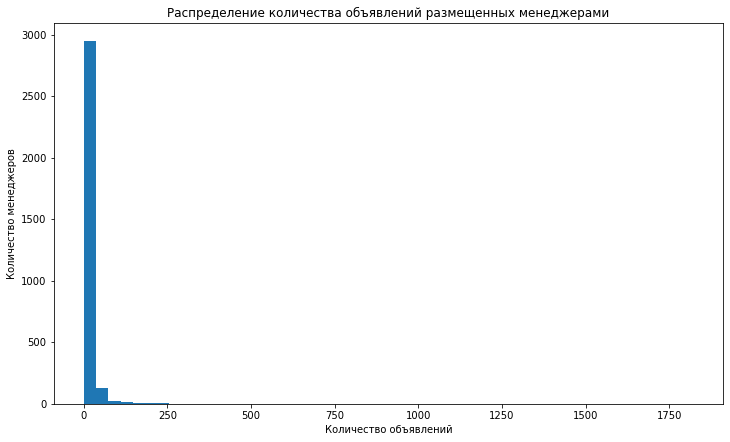

In [57]:
plt.figure(figsize=(12,7))
plt.hist(df.manager_id.value_counts(), bins=50)
plt.xlabel('Количество объявлений')
plt.ylabel('Количество менеджеров')
plt.title('Распределение количества объявлений размещенных менеджерами');

In [58]:
df.manager_id.value_counts().mean()

11.027458492975734

Много уникальных значений, более 3000, если будем кодировать, то моделька разрастётся. Предлагаю разбить менджеров, как и target, на high, low и medium.

In [59]:
s = df.manager_id.value_counts()
m = s.mean()
def func(x):
    global s, m
    if s[x] <= m:
        return 0
    elif m < s[x] <= 80:
        return 1
    else:
        return 2
df['manager_id'] = df['manager_id'].apply(func)

In [60]:
df.head()

,bathrooms,bedrooms,description,features,latitude,longitude,manager_id,photos,price,TARGET,month,day,hour,minute,second,weekday,Elevator,Hardwood Floors,Dishwasher,Doorman,Cats Allowed,Laundry in Building,Dogs Allowed,No Fee,Fitness Center,Laundry in Unit,Outdoor Space,Roof Deck,Dining Room,Pre-War,High Speed Internet,Balcony,Terrace,quantity_of_feature
0,1,3,1,"['Laundry In Unit', 'No Fee', 'Elevator']",40.7647,-73.9918,2,3,4495,1,5,19,18,6,27,3,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,3
1,1,1,1,"['Dogs Allowed', 'Cats Allowed', 'No Fee']",40.7275,-74.0322,1,13,2570,1,6,16,2,1,49,3,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,3
2,1,0,1,"['Elevator', 'Hardwood Floors']",40.7798,-73.9751,1,6,1795,0,5,4,2,42,50,2,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
3,1,2,1,"['Swimming Pool', 'Doorman', 'Elevator', 'Fitn...",40.7081,-74.0065,2,4,3400,0,5,12,5,57,56,3,1,1,1,1,0,0,0,1,1,1,0,0,0,0,0,0,0,8
4,1,3,1,"['Laundry in Building', 'Laundry in Unit', 'Di...",40.7416,-74.0025,1,3,5695,0,6,16,6,6,15,3,0,1,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,4


In [61]:
df = df.drop(columns=['features']) 

In [62]:
df.head()

,bathrooms,bedrooms,description,latitude,longitude,manager_id,photos,price,TARGET,month,day,hour,minute,second,weekday,Elevator,Hardwood Floors,Dishwasher,Doorman,Cats Allowed,Laundry in Building,Dogs Allowed,No Fee,Fitness Center,Laundry in Unit,Outdoor Space,Roof Deck,Dining Room,Pre-War,High Speed Internet,Balcony,Terrace,quantity_of_feature
0,1,3,1,40.7647,-73.9918,2,3,4495,1,5,19,18,6,27,3,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,3
1,1,1,1,40.7275,-74.0322,1,13,2570,1,6,16,2,1,49,3,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,3
2,1,0,1,40.7798,-73.9751,1,6,1795,0,5,4,2,42,50,2,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
3,1,2,1,40.7081,-74.0065,2,4,3400,0,5,12,5,57,56,3,1,1,1,1,0,0,0,1,1,1,0,0,0,0,0,0,0,8
4,1,3,1,40.7416,-74.0025,1,3,5695,0,6,16,6,6,15,3,0,1,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,4


Сильная обратная связь между широтой долготой, также средняя прямая связь между ванными и спальнями. В остальных случаях связи нет

In [63]:
na_columns = df.isna().any()[df.isna().any()]  
na_columns

Series([], dtype: bool)

Пустых значений нет

In [64]:
columns = ['bathrooms', 'bedrooms', 'description', 'latitude',
        'longitude', 'manager_id', 'photos', 'price', 'quantity_of_feature',
          'month', 'day', 'hour', 'minute', 'second', 'weekday', 'Elevator',
           'Hardwood Floors', 'Dishwasher', 'Doorman', 'Cats Allowed',
           'Laundry in Building', 'Dogs Allowed', 'No Fee', 'Fitness Center',
           'Laundry in Unit', 'Outdoor Space', 'Roof Deck', 'Dining Room', 'Pre-War',
           'High Speed Internet', 'Balcony', 'Terrace']

normalizer = StandardScaler()
normalizer.fit(df[columns])
normalized = normalizer.transform(df[columns])

norm_columns = ['norm_' + i for i in columns]
df[norm_columns] = normalized
df = df.drop(columns=columns)



In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34538 entries, 0 to 34545
Data columns (total 33 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   TARGET                    34538 non-null  int32  
 1   norm_bathrooms            34538 non-null  float64
 2   norm_bedrooms             34538 non-null  float64
 3   norm_description          34538 non-null  float64
 4   norm_latitude             34538 non-null  float64
 5   norm_longitude            34538 non-null  float64
 6   norm_manager_id           34538 non-null  float64
 7   norm_photos               34538 non-null  float64
 8   norm_price                34538 non-null  float64
 9   norm_quantity_of_feature  34538 non-null  float64
 10  norm_month                34538 non-null  float64
 11  norm_day                  34538 non-null  float64
 12  norm_hour                 34538 non-null  float64
 13  norm_minute               34538 non-null  float64
 14  norm_s

# Выбор целевой метрики

Перед нами стоит задача классификации. Приэтом классы распределены далеко неравномерно, кроме этого, мы доля medium и high занимают 30% (по 22% и 8% соответсвтенно). Интуитивно понятной, очевидной и почти неиспользуемой метрикой является `accuracy` — доля правильных ответов алгоритма. Эта метрика бесполезна в нашей задаче с неравными классами. `Precision` и `recall` не зависят от соотношения классов и потому применимы в условиях несбалансированных выборок. Понятно что чем выше точность и полнота, тем лучше. Но мы пойдём дальше и будем искать некий баланс. Поэтому, хотелось бы иметь некую метрику которая объединяла бы в себе информацию о точности и полноте нашего алгоритма. Именно такой метрикой является `f1-score`. Его и будем оптимизировать

# Проведение экспериментов 

In [66]:
X = df.drop(columns=['TARGET'])
y = df['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.65)

In [67]:
def result(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    targets = ["low", "medium", "high"]
    print(classification_report(y_test, y_pred, target_names=targets, digits=4))

### DummyClassifier

In [68]:
dummy = DummyClassifier(random_state=42)
result(dummy, X_train, X_test, y_train, y_test)

              precision    recall  f1-score   support

         low     0.6935    1.0000    0.8190      8384
      medium     0.0000    0.0000    0.0000      2720
        high     0.0000    0.0000    0.0000       985

    accuracy                         0.6935     12089
   macro avg     0.2312    0.3333    0.2730     12089
weighted avg     0.4810    0.6935    0.5680     12089



### LogisticRegression

In [69]:
log_reg = LogisticRegression(random_state=42)
result(log_reg, X_train, X_test, y_train, y_test)

              precision    recall  f1-score   support

         low     0.7222    0.9592    0.8240      8384
      medium     0.3901    0.1338    0.1993      2720
        high     0.4762    0.0102    0.0199       985

    accuracy                         0.6962     12089
   macro avg     0.5295    0.3677    0.3477     12089
weighted avg     0.6275    0.6962    0.6179     12089



### DecisionTreeClassifier

In [70]:
dec_tree = DecisionTreeClassifier(random_state=42)
result(dec_tree, X_train, X_test, y_train, y_test)

              precision    recall  f1-score   support

         low     0.7885    0.7752    0.7818      8384
      medium     0.3371    0.3574    0.3470      2720
        high     0.2759    0.2701    0.2730       985

    accuracy                         0.6400     12089
   macro avg     0.4672    0.4675    0.4672     12089
weighted avg     0.6452    0.6400    0.6425     12089



### LinearSVC

In [71]:
linear_svc = LinearSVC(random_state=42)
result(linear_svc, X_train, X_test, y_train, y_test)

              precision    recall  f1-score   support

         low     0.7149    0.9695    0.8230      8384
      medium     0.3806    0.1007    0.1593      2720
        high     0.0000    0.0000    0.0000       985

    accuracy                         0.6950     12089
   macro avg     0.3652    0.3567    0.3274     12089
weighted avg     0.5814    0.6950    0.6066     12089



### StackingClassifier

In [72]:
estimators=[('DecTree', DecisionTreeClassifier()),
            ('LenearSVC', LinearSVC())]

model = StackingClassifier(estimators=estimators, final_estimator=LinearSVC())
result(model, X_train, X_test, y_train, y_test)

              precision    recall  f1-score   support

         low     0.7313    0.9568    0.8290      8384
      medium     0.4036    0.1662    0.2354      2720
        high     0.0000    0.0000    0.0000       985

    accuracy                         0.7010     12089
   macro avg     0.3783    0.3743    0.3548     12089
weighted avg     0.5980    0.7010    0.6279     12089



### BaggingClassifier

In [73]:
models = [DecisionTreeClassifier(random_state=42),
          LinearSVC(random_state=42),
          LogisticRegression(random_state=42)]

for model in models:
    print(model)
    result(BaggingClassifier(model), X_train, X_test, y_train, y_test)

DecisionTreeClassifier(random_state=42)
              precision    recall  f1-score   support

         low     0.7790    0.8961    0.8334      8384
      medium     0.4158    0.3022    0.3500      2720
        high     0.4647    0.2203    0.2989       985

    accuracy                         0.7074     12089
   macro avg     0.5531    0.4729    0.4941     12089
weighted avg     0.6716    0.7074    0.6811     12089

LinearSVC(random_state=42)
              precision    recall  f1-score   support

         low     0.7130    0.9707    0.8221      8384
      medium     0.3763    0.0934    0.1496      2720
        high     0.0000    0.0000    0.0000       985

    accuracy                         0.6942     12089
   macro avg     0.3631    0.3547    0.3239     12089
weighted avg     0.5791    0.6942    0.6038     12089

LogisticRegression(random_state=42)
              precision    recall  f1-score   support

         low     0.7232    0.9575    0.8240      8384
      medium     0.3882   

### RandomForestClassifier

In [74]:
forest = RandomForestClassifier(max_depth=10, random_state=42)
result(forest, X_train, X_test, y_train, y_test)

              precision    recall  f1-score   support

         low     0.7156    0.9883    0.8301      8384
      medium     0.4207    0.0614    0.1072      2720
        high     0.6903    0.0792    0.1421       985

    accuracy                         0.7057     12089
   macro avg     0.6088    0.3763    0.3598     12089
weighted avg     0.6472    0.7057    0.6114     12089



### GradientBoostingClassifier

In [75]:
boosting = GradientBoostingClassifier(random_state=42)
result(boosting, X_train, X_test, y_train, y_test)

              precision    recall  f1-score   support

         low     0.7598    0.9517    0.8450      8384
      medium     0.4272    0.2147    0.2858      2720
        high     0.6154    0.1381    0.2255       985

    accuracy                         0.7196     12089
   macro avg     0.6008    0.4348    0.4521     12089
weighted avg     0.6732    0.7196    0.6687     12089



### XGBClassifier

In [76]:
xgboosting = XGBClassifier(random_state=42)
xgboosting.fit(X_train, y_train)
y_pred = xgboosting.predict(X_test)
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.7990    0.9163    0.8536      8384
           1     0.4543    0.3379    0.3875      2720
           2     0.5233    0.2396    0.3287       985

    accuracy                         0.7310     12089
   macro avg     0.5922    0.4979    0.5233     12089
weighted avg     0.6989    0.7310    0.7060     12089



In [77]:
xgboosting = XGBClassifier(booster='dart', random_state=42)
xgboosting.fit(X_train, y_train)
y_pred = xgboosting.predict(X_test)
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.7990    0.9163    0.8536      8384
           1     0.4543    0.3379    0.3875      2720
           2     0.5233    0.2396    0.3287       985

    accuracy                         0.7310     12089
   macro avg     0.5922    0.4979    0.5233     12089
weighted avg     0.6989    0.7310    0.7060     12089



### LGBMClassifier

In [78]:
lgboosting = LGBMClassifier(learning_rate=1e-2, random_state=42)
result(lgboosting, X_train, X_test, y_train, y_test)

              precision    recall  f1-score   support

         low     0.6991    0.9995    0.8227      8384
      medium     0.4706    0.0029    0.0058      2720
        high     0.7294    0.0629    0.1159       985

    accuracy                         0.6990     12089
   macro avg     0.6330    0.3551    0.3148     12089
weighted avg     0.6501    0.6990    0.5813     12089



### CatBoostClassifier

In [79]:
catboostc = catboost.CatBoostClassifier(verbose=False)
result(catboostc, X_train, X_test, y_train, y_test)

              precision    recall  f1-score   support

         low     0.7982    0.9226    0.8559      8384
      medium     0.4549    0.3265    0.3801      2720
        high     0.5426    0.2457    0.3382       985

    accuracy                         0.7333     12089
   macro avg     0.5986    0.4982    0.5247     12089
weighted avg     0.7001    0.7333    0.7067     12089



Лучше всего себя показал `CatBoostClassifier`.

Попробуем подобрать оптимальные гиперпараметры для него.

In [80]:
def objective(trial):
    targets = ["low", "medium", "high"]
    param = {
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 1, 12),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        "used_ram_limit": "3gb",
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    gbm = catboost.CatBoostClassifier(**param, verbose=False)
    result(gbm, X_train, X_test, y_train, y_test)
    return(f1_score(y_test, y_pred, average='weighted'))

In [81]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50, timeout=600)

[I 2023-02-11 12:46:13,180] A new study created in memory with name: no-name-fbd84f1b-e7fe-4926-a025-7d6a169adcb6
[I 2023-02-11 12:46:27,969] Trial 0 finished with value: 0.7059655878873248 and parameters: {'colsample_bylevel': 0.01028334011871179, 'depth': 3, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.5206355509657808}. Best is trial 0 with value: 0.7059655878873248.


              precision    recall  f1-score   support

         low     0.7001    0.9943    0.8216      8384
      medium     0.3553    0.0199    0.0376      2720
        high     0.5667    0.0173    0.0335       985

    accuracy                         0.6954     12089
   macro avg     0.5407    0.3438    0.2976     12089
weighted avg     0.6116    0.6954    0.5810     12089



[I 2023-02-11 12:46:47,921] Trial 1 finished with value: 0.7059655878873248 and parameters: {'colsample_bylevel': 0.07522509496310181, 'depth': 1, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.2856254917735944}. Best is trial 0 with value: 0.7059655878873248.


              precision    recall  f1-score   support

         low     0.7289    0.9690    0.8320      8384
      medium     0.3734    0.1074    0.1668      2720
        high     0.5963    0.0975    0.1675       985

    accuracy                         0.7041     12089
   macro avg     0.5662    0.3913    0.3888     12089
weighted avg     0.6381    0.7041    0.6281     12089



[I 2023-02-11 12:48:55,882] Trial 2 finished with value: 0.7059655878873248 and parameters: {'colsample_bylevel': 0.08566116348978672, 'depth': 11, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.32311726325365586}. Best is trial 0 with value: 0.7059655878873248.


              precision    recall  f1-score   support

         low     0.7850    0.9278    0.8504      8384
      medium     0.4535    0.2960    0.3582      2720
        high     0.5396    0.2213    0.3139       985

    accuracy                         0.7281     12089
   macro avg     0.5927    0.4817    0.5075     12089
weighted avg     0.6904    0.7281    0.6960     12089



[I 2023-02-11 12:49:41,447] Trial 3 finished with value: 0.7059655878873248 and parameters: {'colsample_bylevel': 0.0724026181845452, 'depth': 9, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 8.160455287208825}. Best is trial 0 with value: 0.7059655878873248.


              precision    recall  f1-score   support

         low     0.7667    0.9423    0.8455      8384
      medium     0.4486    0.2408    0.3134      2720
        high     0.5446    0.1797    0.2702       985

    accuracy                         0.7223     12089
   macro avg     0.5866    0.4543    0.4764     12089
weighted avg     0.6770    0.7223    0.6789     12089



[I 2023-02-11 12:49:43,797] Trial 4 finished with value: 0.7059655878873248 and parameters: {'colsample_bylevel': 0.09256372253947205, 'depth': 2, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.27852767668262324}. Best is trial 0 with value: 0.7059655878873248.


              precision    recall  f1-score   support

         low     0.7483    0.9571    0.8399      8384
      medium     0.4140    0.1787    0.2496      2720
        high     0.6094    0.1188    0.1988       985

    accuracy                         0.7136     12089
   macro avg     0.5905    0.4182    0.4294     12089
weighted avg     0.6618    0.7136    0.6549     12089



[I 2023-02-11 12:52:35,607] Trial 5 finished with value: 0.7059655878873248 and parameters: {'colsample_bylevel': 0.09760718252809653, 'depth': 11, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 0 with value: 0.7059655878873248.


              precision    recall  f1-score   support

         low     0.7952    0.9232    0.8544      8384
      medium     0.4604    0.3268    0.3823      2720
        high     0.5259    0.2264    0.3165       985

    accuracy                         0.7322     12089
   macro avg     0.5938    0.4921    0.5177     12089
weighted avg     0.6979    0.7322    0.7043     12089



[I 2023-02-11 12:52:38,830] Trial 6 finished with value: 0.7059655878873248 and parameters: {'colsample_bylevel': 0.03853318959517308, 'depth': 12, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.44533485622624436}. Best is trial 0 with value: 0.7059655878873248.


              precision    recall  f1-score   support

         low     0.7525    0.9549    0.8417      8384
      medium     0.4307    0.1908    0.2645      2720
        high     0.5714    0.1421    0.2276       985

    accuracy                         0.7168     12089
   macro avg     0.5849    0.4293    0.4446     12089
weighted avg     0.6654    0.7168    0.6618     12089



[I 2023-02-11 12:53:38,999] Trial 7 finished with value: 0.7059655878873248 and parameters: {'colsample_bylevel': 0.06207162560984868, 'depth': 11, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 3.3027825936508726}. Best is trial 0 with value: 0.7059655878873248.


              precision    recall  f1-score   support

         low     0.7719    0.9413    0.8482      8384
      medium     0.4463    0.2507    0.3211      2720
        high     0.5371    0.1838    0.2738       985

    accuracy                         0.7242     12089
   macro avg     0.5851    0.4586    0.4811     12089
weighted avg     0.6795    0.7242    0.6828     12089



[I 2023-02-11 12:53:42,186] Trial 8 finished with value: 0.7059655878873248 and parameters: {'colsample_bylevel': 0.07197382328902478, 'depth': 5, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.3590395261796997}. Best is trial 0 with value: 0.7059655878873248.


              precision    recall  f1-score   support

         low     0.7728    0.9441    0.8499      8384
      medium     0.4607    0.2540    0.3275      2720
        high     0.5850    0.2061    0.3048       985

    accuracy                         0.7287     12089
   macro avg     0.6062    0.4681    0.4941     12089
weighted avg     0.6873    0.7287    0.6879     12089



[I 2023-02-11 12:53:58,607] Trial 9 finished with value: 0.7059655878873248 and parameters: {'colsample_bylevel': 0.010364265591404196, 'depth': 7, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.5849723462665674}. Best is trial 0 with value: 0.7059655878873248.


              precision    recall  f1-score   support

         low     0.7013    0.9932    0.8221      8384
      medium     0.3784    0.0257    0.0482      2720
        high     0.5667    0.0173    0.0335       985

    accuracy                         0.6960     12089
   macro avg     0.5488    0.3454    0.3013     12089
weighted avg     0.6177    0.6960    0.5837     12089



[I 2023-02-11 12:54:00,666] Trial 10 finished with value: 0.7059655878873248 and parameters: {'colsample_bylevel': 0.01939188103180585, 'depth': 4, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 0 with value: 0.7059655878873248.


              precision    recall  f1-score   support

         low     0.7181    0.9792    0.8286      8384
      medium     0.3958    0.0824    0.1363      2720
        high     0.6111    0.0558    0.1023       985

    accuracy                         0.7022     12089
   macro avg     0.5750    0.3725    0.3557     12089
weighted avg     0.6369    0.7022    0.6137     12089



[I 2023-02-11 12:54:21,986] Trial 11 finished with value: 0.7059655878873248 and parameters: {'colsample_bylevel': 0.04264366330085199, 'depth': 1, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.9705679154471898}. Best is trial 0 with value: 0.7059655878873248.


              precision    recall  f1-score   support

         low     0.7201    0.9732    0.8277      8384
      medium     0.3453    0.0816    0.1320      2720
        high     0.5739    0.0670    0.1200       985

    accuracy                         0.6987     12089
   macro avg     0.5464    0.3739    0.3599     12089
weighted avg     0.6238    0.6987    0.6135     12089



[I 2023-02-11 12:54:39,157] Trial 12 finished with value: 0.7059655878873248 and parameters: {'colsample_bylevel': 0.043579260721647736, 'depth': 3, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.11261400105935299}. Best is trial 0 with value: 0.7059655878873248.


              precision    recall  f1-score   support

         low     0.7378    0.9633    0.8356      8384
      medium     0.3933    0.1390    0.2054      2720
        high     0.6099    0.1127    0.1902       985

    accuracy                         0.7085     12089
   macro avg     0.5803    0.4050    0.4104     12089
weighted avg     0.6499    0.7085    0.6412     12089



[I 2023-02-11 12:54:56,142] Trial 13 finished with value: 0.7059655878873248 and parameters: {'colsample_bylevel': 0.02722610576254251, 'depth': 1, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6001630750148581}. Best is trial 0 with value: 0.7059655878873248.


              precision    recall  f1-score   support

         low     0.7106    0.9843    0.8254      8384
      medium     0.3804    0.0555    0.0969      2720
        high     0.5625    0.0457    0.0845       985

    accuracy                         0.6988     12089
   macro avg     0.5512    0.3618    0.3356     12089
weighted avg     0.6243    0.6988    0.6011     12089



[I 2023-02-11 12:55:16,724] Trial 14 finished with value: 0.7059655878873248 and parameters: {'colsample_bylevel': 0.06352838152508772, 'depth': 6, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 0 with value: 0.7059655878873248.


              precision    recall  f1-score   support

         low     0.7752    0.9393    0.8494      8384
      medium     0.4506    0.2680    0.3361      2720
        high     0.5801    0.1838    0.2791       985

    accuracy                         0.7267     12089
   macro avg     0.6020    0.4637    0.4882     12089
weighted avg     0.6862    0.7267    0.6874     12089



[I 2023-02-11 12:55:35,696] Trial 15 finished with value: 0.7059655878873248 and parameters: {'colsample_bylevel': 0.07836536394558587, 'depth': 3, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.7357547700584917}. Best is trial 0 with value: 0.7059655878873248.


              precision    recall  f1-score   support

         low     0.7635    0.9501    0.8466      8384
      medium     0.4440    0.2316    0.3044      2720
        high     0.6017    0.1442    0.2326       985

    accuracy                         0.7228     12089
   macro avg     0.6030    0.4420    0.4612     12089
weighted avg     0.6784    0.7228    0.6746     12089



[I 2023-02-11 12:55:51,111] Trial 16 finished with value: 0.7059655878873248 and parameters: {'colsample_bylevel': 0.05472889023445283, 'depth': 3, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7346710619741804}. Best is trial 0 with value: 0.7059655878873248.


              precision    recall  f1-score   support

         low     0.7500    0.9562    0.8407      8384
      medium     0.4256    0.1871    0.2600      2720
        high     0.6275    0.1299    0.2153       985

    accuracy                         0.7159     12089
   macro avg     0.6010    0.4244    0.4386     12089
weighted avg     0.6670    0.7159    0.6591     12089



[I 2023-02-11 12:56:11,955] Trial 17 finished with value: 0.7059655878873248 and parameters: {'colsample_bylevel': 0.05791245664324259, 'depth': 6, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 0 with value: 0.7059655878873248.


              precision    recall  f1-score   support

         low     0.7733    0.9413    0.8491      8384
      medium     0.4537    0.2632    0.3332      2720
        high     0.5574    0.1726    0.2636       985

    accuracy                         0.7261     12089
   macro avg     0.5948    0.4590    0.4819     12089
weighted avg     0.6838    0.7261    0.6853     12089



[I 2023-02-11 12:56:18,885] Trial 18 finished with value: 0.7059655878873248 and parameters: {'colsample_bylevel': 0.08234532326679314, 'depth': 8, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.90104312200772}. Best is trial 0 with value: 0.7059655878873248.


              precision    recall  f1-score   support

         low     0.7862    0.9289    0.8516      8384
      medium     0.4535    0.2974    0.3592      2720
        high     0.5263    0.2132    0.3035       985

    accuracy                         0.7285     12089
   macro avg     0.5887    0.4798    0.5048     12089
weighted avg     0.6902    0.7285    0.6962     12089



In [82]:
print("Best trial:")
trial = study.best_trial

print(f"Value: {trial.value}")

print("Params: ")
for key, value in trial.params.items():
    print(f"{key}: {value}")

Best trial:
Value: 0.7059655878873248
Params: 
colsample_bylevel: 0.01028334011871179
depth: 3
boosting_type: Ordered
bootstrap_type: Bernoulli
subsample: 0.5206355509657808


# Анализ ошибок модели

В силу того, что данные не сбалансированные, модель очень часто ошибается на `medium` и `high` (классах, которые суммарно набирают 30%), однако, так как, по сути, задача сводится к выискиванию `low` объявления, чтобы мы могли их редактировать, тем самым повышая его популярность. В основном, класс `low` определяется не так уж и плохо, а значит, что с главной задачей мы более менее справляемся. Проанализируем ошибки. 

In [83]:
the_best_catboost = catboost.CatBoostClassifier(verbose=False)
the_best_catboost.fit(X_train, y_train)
y_pred = the_best_catboost.predict(X_test)

errors = X_test.copy()
errors['target'] = y_test
errors['pred'] = y_pred
errors = errors[errors.target != errors.pred]

In [84]:
errors.head(15)

,norm_bathrooms,norm_bedrooms,norm_description,norm_latitude,norm_longitude,norm_manager_id,norm_photos,norm_price,norm_quantity_of_feature,norm_month,norm_day,norm_hour,norm_minute,norm_second,norm_weekday,norm_Elevator,norm_Hardwood Floors,norm_Dishwasher,norm_Doorman,norm_Cats Allowed,norm_Laundry in Building,norm_Dogs Allowed,norm_No Fee,norm_Fitness Center,norm_Laundry in Unit,norm_Outdoor Space,norm_Roof Deck,norm_Dining Room,norm_Pre-War,norm_High Speed Internet,norm_Balcony,norm_Terrace,target,pred
14033,1.655490,1.307030,0.0,0.813948,-0.074417,-0.029739,0.376310,0.038449,0.389646,1.190243,1.426671,-0.422014,-1.682099,-0.263502,-1.630930,0.944334,1.044234,1.186947,-0.863009,1.047876,1.417044,1.113537,1.320089,-0.605204,-0.466183,-0.400786,-0.391885,-0.343072,-0.475865,-0.309321,-0.255340,-0.221912,0,1
30159,1.655490,1.307030,0.0,-0.084791,-0.149419,-0.029739,0.091194,0.042250,1.953814,-1.238555,1.668772,-0.422014,-1.498322,0.898424,0.604927,0.944334,1.044234,1.186947,1.158737,1.047876,1.417044,1.113537,-0.757525,-0.605204,2.145079,2.495100,2.551769,2.914839,-0.475865,-0.309321,3.916344,4.506285,0,1
13580,-0.413827,0.411387,0.0,-0.186571,0.898819,-0.029739,0.376310,-0.052774,-0.131744,1.190243,-1.115391,-0.660605,-0.456919,-0.321599,-1.630930,0.944334,1.044234,1.186947,-0.863009,-0.954311,1.417044,-0.898040,-0.757525,-0.605204,-0.466183,-0.400786,-0.391885,-0.343072,2.101434,-0.309321,-0.255340,-0.221912,0,1
20101,-0.413827,0.411387,0.0,-0.647462,-0.456568,-1.456316,0.091194,-0.043272,-0.913828,1.190243,-1.357492,-0.183423,-1.743358,-0.553984,1.163891,-1.058947,-0.957640,-0.842497,-0.863009,1.047876,-0.705695,-0.898040,1.320089,-0.605204,-0.466183,-0.400786,-0.391885,-0.343072,-0.475865,-0.309321,-0.255340,-0.221912,1,2
13782,-0.413827,0.411387,0.0,-0.468867,-0.120847,-0.029739,-0.193921,-0.056575,-0.913828,-0.024156,0.458266,-0.660605,0.768262,0.259364,0.045963,-1.058947,1.044234,1.186947,-0.863009,-0.954311,-0.705695,-0.898040,-0.757525,-0.605204,-0.466183,-0.400786,-0.391885,-0.343072,-0.475865,-0.309321,-0.255340,-0.221912,1,2
34116,1.655490,1.307030,0.0,-0.050224,0.525597,-0.029739,0.376310,0.002340,2.214509,-1.238555,0.942469,-0.660605,-0.395660,0.259364,1.163891,0.944334,-0.957640,1.186947,1.158737,1.047876,1.417044,1.113537,1.320089,1.652334,2.145079,2.495100,2.551769,2.914839,-0.475865,3.232892,3.916344,-0.221912,1,0
21482,-0.413827,1.307030,0.0,-0.883669,-0.790504,1.396837,0.091194,-0.004312,0.911035,1.190243,-0.025936,2.441077,1.625888,0.201268,-0.513002,0.944334,-0.957640,-0.842497,1.158737,1.047876,-0.705695,1.113537,1.320089,1.652334,-0.466183,2.495100,-0.391885,-0.343072,-0.475865,-0.309321,-0.255340,-0.221912,0,1
28763,-0.413827,-0.484256,0.0,-0.897112,-0.729789,-1.456316,0.946541,-0.032629,1.432425,-0.024156,0.700368,2.679668,-1.130768,-0.263502,1.163891,0.944334,-0.957640,-0.842497,1.158737,1.047876,-0.705695,1.113537,1.320089,1.652334,-0.466183,2.495100,-0.391885,-0.343072,-0.475865,-0.309321,-0.255340,-0.221912,1,0
7047,-0.413827,-0.484256,0.0,0.201346,0.216661,-0.029739,-0.479037,-0.064367,-0.653133,-0.024156,0.700368,-0.660605,1.013298,-1.715910,1.163891,-1.058947,1.044234,1.186947,-0.863009,-0.954311,-0.705695,-0.898040,-0.757525,-0.605204,-0.466183,-0.400786,-0.391885,-0.343072,2.101434,-0.309321,-0.255340,-0.221912,1,0
27469,-0.413827,-0.484256,0.0,-0.155845,-0.165490,-0.029739,0.091194,-0.035670,0.650341,1.190243,-1.720644,-0.899196,0.645744,-0.263502,-0.513002,0.944334,1.044234,1.186947,-0.863009,1.047876,-0.705695,1.113537,-0.757525,-0.605204,-0.466183,-0.400786,-0.391885,2.914839,-0.475865,-0.309321,-0.255340,-0.221912,1,0


Как мы видим зачастую модель, если сомневается, то выдаёт `low` как наиболее популярный класс, в данных его 70% против 30% двух других классов. Собственно, такое решение вполне приемлемо, так как в основном нужно выявлять объявления с низкой популярностью.